<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/CyberAttackDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlowChart

In [2]:
from graphviz import Digraph

dot = Digraph(comment='Cyber Attack Detection Flowchart')
dot.node('A', 'Start')
dot.node('B', 'Define Problem & Scope')
dot.node('C', 'Collect Dataset')
dot.node('D', 'Preprocess Data')
dot.node('E', 'Perform EDA')
dot.node('F', 'Select Model')
dot.node('G', 'Train Model')
dot.node('H', 'Evaluate Model')
dot.node('I', 'Optimize Model')
dot.node('J', 'Deploy Model')
dot.node('K', 'Monitor & Retrain')
dot.node('L', 'End')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HJ', 'JK', 'KL'])
dot.edge('H', 'I', label='If performance poor')
dot.edge('I', 'G', label='Retrain')

dot.render('flowchart', format='png', view=True)

'flowchart.png'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
from IPython.display import Image
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import psutil
import warnings
warnings.filterwarnings('ignore')

# Function to monitor memory usage
def print_memory_usage(step_name):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"{step_name} - Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Step 1: Setup and Extract Dataset
def setup_and_extract():
    print("\nStep 1: Setup and Extract Dataset")
    drive.mount('/content/drive', force_remount=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'
    extract_dir = '/content/cicids2017/'

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Dataset extracted successfully.")
    except FileNotFoundError:
        print(f"Error: Zip file not found at {zip_path}. Please check the path.")
        return None, None

    csv_files = []
    for root, _, files in os.walk(extract_dir):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    print("Found CSV files:")
    for file in csv_files:
        print(f"  {file}")

    if not csv_files:
        print("Error: No CSV files found in", extract_dir)
        return None, None

    print_memory_usage("Step 1")
    return csv_files, extract_dir

csv_files, extract_dir = setup_and_extract()
if csv_files is None:
    raise SystemExit("Stopping due to error in Step 1.")


Step 1: Setup and Extract Dataset
Mounted at /content/drive
Using device: cuda
Dataset extracted successfully.
Found CSV files:
  /content/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  /content/cicids2017/Tuesday-WorkingHours.pcap_ISCX.csv
  /content/cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  /content/cicids2017/Wednesday-workingHours.pcap_ISCX.csv
  /content/cicids2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  /content/cicids2017/Friday-WorkingHours-Morning.pcap_ISCX.csv
  /content/cicids2017/Monday-WorkingHours.pcap_ISCX.csv
  /content/cicids2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Step 1 - Memory usage: 818.27 MB


In [9]:
# Step 2: Load and Combine Datasets
def load_and_combine_data(csv_files):
    print("\nStep 2: Load and Combine Datasets")
    keep_cols = [' Destination Port', ' Flow Duration', ' Total Fwd Packets',
                 ' Total Backward Packets', 'Flow Bytes/s', ' Label']
    data_frames = []

    for file in csv_files:
        try:
            chunks = pd.read_csv(file, encoding='latin1', low_memory=False,
                                usecols=keep_cols, chunksize=100000)
            for chunk in chunks:
                for col in chunk.select_dtypes(include=['int64']).columns:
                    chunk[col] = chunk[col].astype('int32')
                for col in chunk.select_dtypes(include=['float64']).columns:
                    chunk[col] = chunk[col].astype('float32')
                data_frames.append(chunk)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_frames:
        print("Error: No data loaded.")
        return None

    df = pd.concat(data_frames, ignore_index=True)
    print(f"Dataset shape: {df.shape}")
    print("\nData types after loading:")
    print(df.dtypes)
    print_memory_usage("Step 2")
    return df

df = load_and_combine_data(csv_files)
if df is None:
    raise SystemExit("Stopping due to error in Step 2.")


Step 2: Load and Combine Datasets
Dataset shape: (2830743, 6)

Data types after loading:
 Destination Port            int32
 Flow Duration               int32
 Total Fwd Packets           int32
 Total Backward Packets      int32
Flow Bytes/s               float32
 Label                      object
dtype: object
Step 2 - Memory usage: 970.13 MB



Step 3: Initial Data Inspection

First 5 rows:
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Flow Bytes/s   Label  
0                        0  4.000000e+06  BENIGN  
1                        1  1.100917e+05  BENIGN  
2                        1  2.307692e+05  BENIGN  
3                        1  3.529412e+05  BENIGN  
4                        0  4.000000e+06  BENIGN  

Column names:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Flow Bytes/s', ' Label']

Data types:
 Destination Port            int32
 Flow Duration               int32
 Total Fwd Packets           int32
 Total Backward Packets      int32
Fl

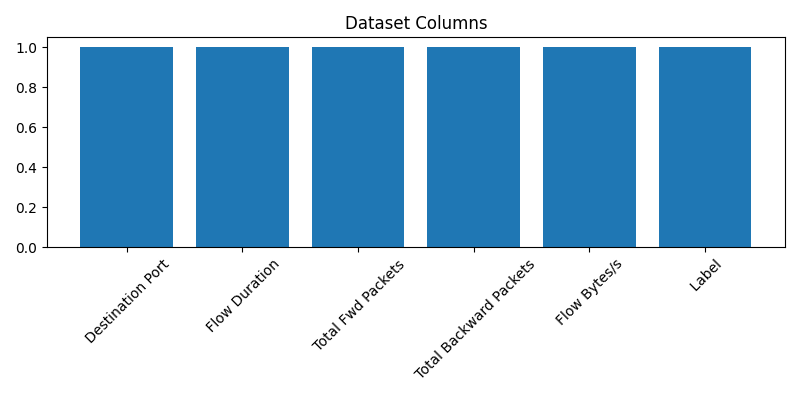

Step 3 - Memory usage: 970.13 MB


In [10]:
# Step 3: Initial Data Inspection
def inspect_data(df):
    print("\nStep 3: Initial Data Inspection")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)
    print("\nBasic statistics:")
    print(df.describe())

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(df.columns)), [1] * len(df.columns))
    plt.xticks(range(len(df.columns)), df.columns, rotation=45)
    plt.title("Dataset Columns")
    plt.tight_layout()
    plt.savefig('columns.png')
    plt.close()
    display(Image('columns.png'))
    print_memory_usage("Step 3")

inspect_data(df)


Step 4: Check for Missing Values

Missing values per column:
Flow Bytes/s    1358
dtype: int64


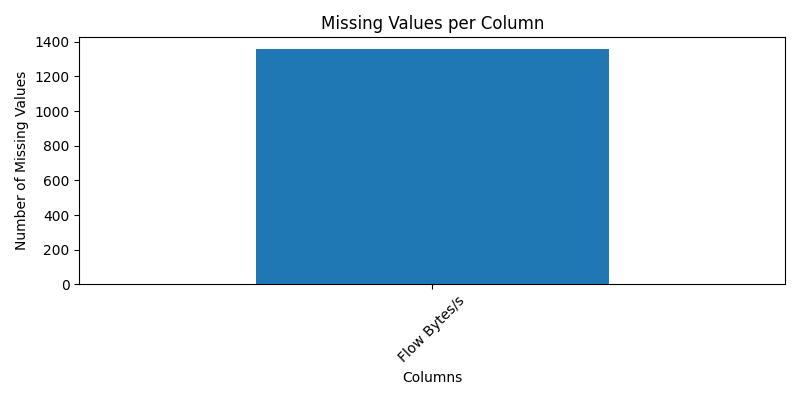

Step 4 - Memory usage: 970.13 MB


In [11]:
# Step 4: Check for Missing Values
def check_missing_values(df):
    print("\nStep 4: Check for Missing Values")
    missing_values = df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])

    if missing_values[missing_values > 0].empty:
        print("No missing values to visualize.")
    else:
        plt.figure(figsize=(8, 4))
        missing_values[missing_values > 0].plot(kind='bar')
        plt.title("Missing Values per Column")
        plt.xlabel("Columns")
        plt.ylabel("Number of Missing Values")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('missing_values.png')
        plt.close()
        display(Image('missing_values.png'))

    print_memory_usage("Step 4")
    return missing_values

missing_values = check_missing_values(df)

In [12]:
# Step 5: Handle Missing Values
def handle_missing_values(df):
    print("\nStep 5: Handle Missing Values")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    numerical_cols = df.select_dtypes(include=['float32', 'int32']).columns
    if not numerical_cols.empty:
        imputer = SimpleImputer(strategy='median')
        df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
        # Ensure data types are preserved
        for col in numerical_cols:
            if col in df.select_dtypes(include=['int32']).columns:
                df[col] = df[col].astype('int32')
            else:
                df[col] = df[col].astype('float32')
    else:
        print("Warning: No numerical columns found for imputation.")

    print("\nMissing values after imputation:")
    print(df.isnull().sum().sum())
    print("\nData types after imputation:")
    print(df.dtypes)
    print_memory_usage("Step 5")
    return df

df = handle_missing_values(df)


Step 5: Handle Missing Values

Missing values after imputation:
0

Data types after imputation:
 Destination Port          float32
 Flow Duration             float32
 Total Fwd Packets         float32
 Total Backward Packets    float32
Flow Bytes/s               float32
 Label                      object
dtype: object
Step 5 - Memory usage: 924.74 MB



Step 6: Analyze Class Distribution

Class distribution:
Label
0    2273097
1     557646
Name: count, dtype: int64


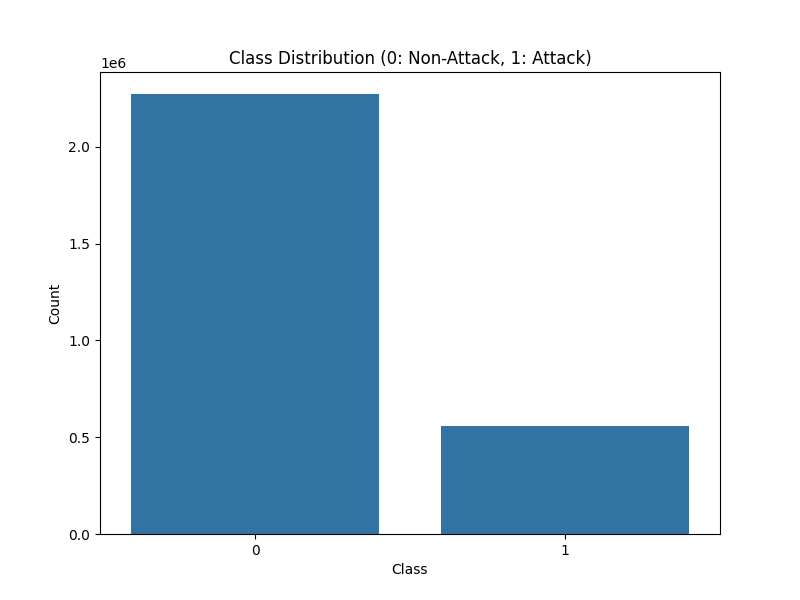


Attack types distribution:
 Label
DoS Hulk                        231073
PortScan                        158930
DDoS                            128027
DoS GoldenEye                    10293
FTP-Patator                       7938
SSH-Patator                       5897
DoS slowloris                     5796
DoS Slowhttptest                  5499
Bot                               1966
Web Attack ï¿½ Brute Force        1507
Web Attack ï¿½ XSS                 652
Infiltration                        36
Web Attack ï¿½ Sql Injection        21
Heartbleed                          11
Name: count, dtype: int64


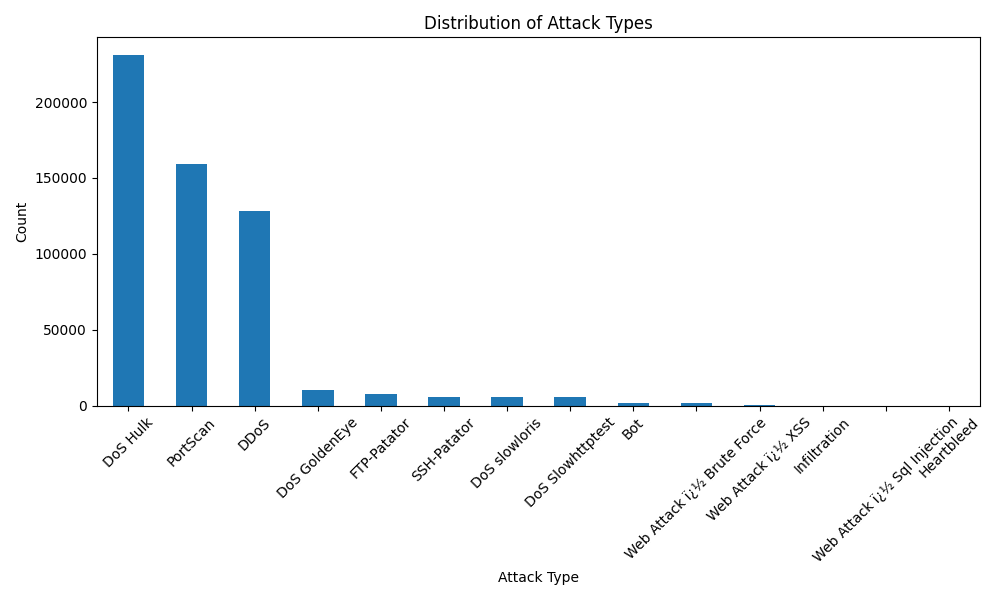


Data types after label mapping:
 Destination Port          float32
 Flow Duration             float32
 Total Fwd Packets         float32
 Total Backward Packets    float32
Flow Bytes/s               float32
 Label                      object
Label                        int32
dtype: object
Step 6 - Memory usage: 893.94 MB


In [13]:
# Step 6: Analyze Class Distribution
def analyze_class_distribution(df):
    print("\nStep 6: Analyze Class Distribution")
    df['Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).astype('int32')
    class_counts = df['Label'].value_counts()
    print("\nClass distribution:")
    print(class_counts)

    plt.figure(figsize=(8, 6))
    sns.countplot(x='Label', data=df)
    plt.title("Class Distribution (0: Non-Attack, 1: Attack)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.savefig('class_distribution.png')
    plt.close()
    display(Image('class_distribution.png'))

    attack_types = df[df['Label'] == 1][' Label'].value_counts()
    print("\nAttack types distribution:")
    print(attack_types)

    plt.figure(figsize=(10, 6))
    attack_types.plot(kind='bar')
    plt.title("Distribution of Attack Types")
    plt.xlabel("Attack Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('attack_types_distribution.png')
    plt.close()
    display(Image('attack_types_distribution.png'))

    print("\nData types after label mapping:")
    print(df.dtypes)
    print_memory_usage("Step 6")
    return df

df = analyze_class_distribution(df)


Step 7: Feature Correlation Analysis

Columns before correlation:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Flow Bytes/s', ' Label', 'Label']

Data types:
 Destination Port          float32
 Flow Duration             float32
 Total Fwd Packets         float32
 Total Backward Packets    float32
Flow Bytes/s               float32
 Label                      object
Label                        int32
dtype: object

Numerical columns for correlation:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Flow Bytes/s']

Correlation matrix (sample):
                          Destination Port   Flow Duration  \
 Destination Port                 1.000000       -0.147851   
 Flow Duration                   -0.147851        1.000000   
 Total Fwd Packets               -0.008556        0.034418   
 Total Backward Packets          -0.008144        0.031150   
Flow Bytes/s                      0.079780       -0.0301

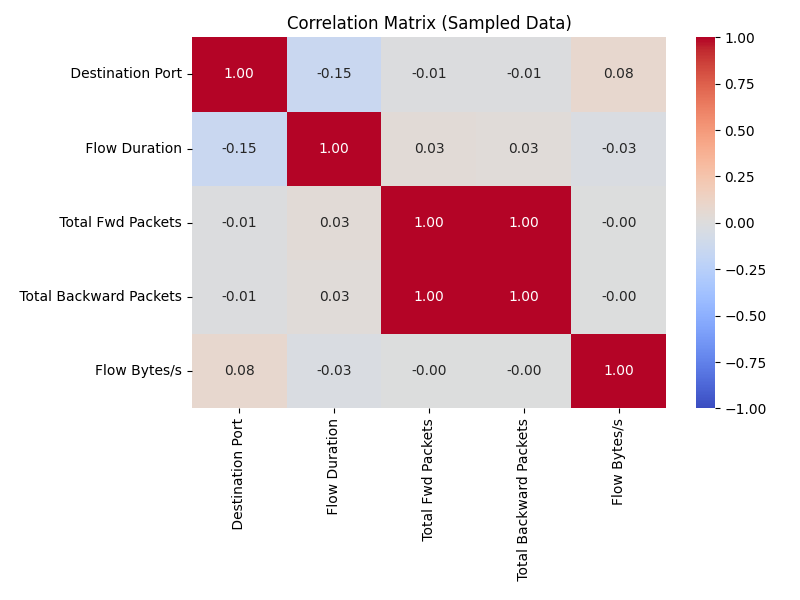

Step 7 - Memory usage: 894.36 MB


In [14]:
# Step 7: Feature Correlation Analysis
def correlation_analysis(df):
    print("\nStep 7: Feature Correlation Analysis")
    # Debug: Check columns and types
    print("\nColumns before correlation:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)

    # Include int64/float64 as fallback
    numerical_cols = df.select_dtypes(include=['float32', 'int32', 'float64', 'int64']).columns
    numerical_cols = [col for col in numerical_cols if col != 'Label']  # Exclude Label
    if not numerical_cols:
        print("Error: No numerical columns found for correlation.")
        print("Available columns:", df.columns.tolist())
        return

    print("\nNumerical columns for correlation:")
    print(numerical_cols)

    sample_df = df[numerical_cols].sample(n=10000, random_state=42)
    corr_matrix = sample_df.corr()
    print("\nCorrelation matrix (sample):")
    print(corr_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title("Correlation Matrix (Sampled Data)")
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.close()
    display(Image('correlation_matrix.png'))

    print_memory_usage("Step 7")

correlation_analysis(df)


Step 8: Feature Distribution Analysis


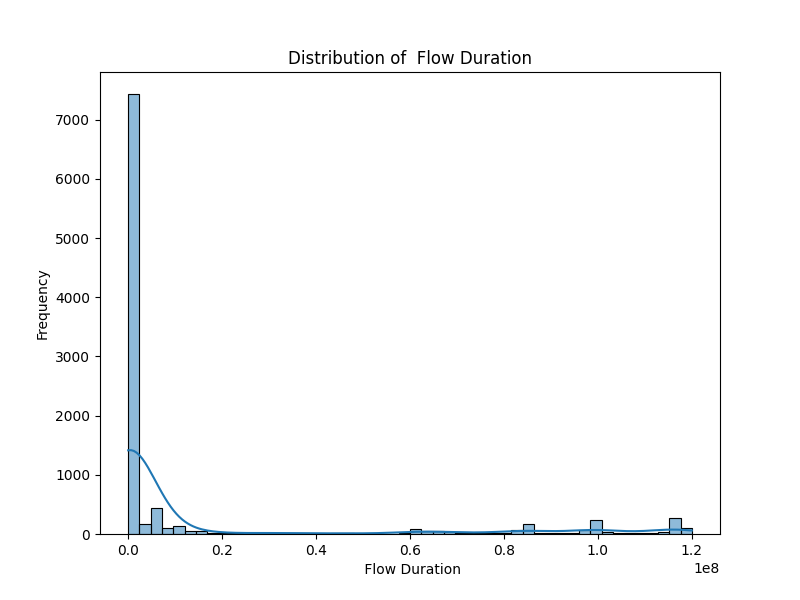

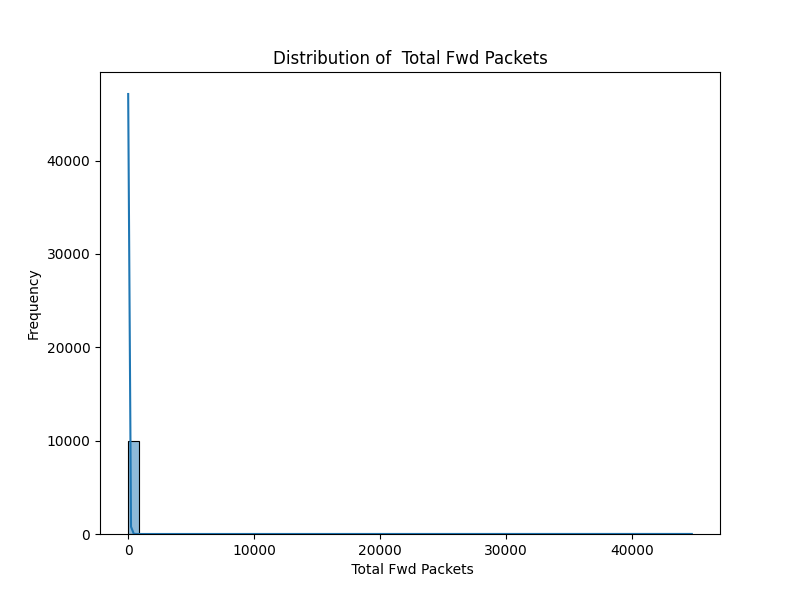

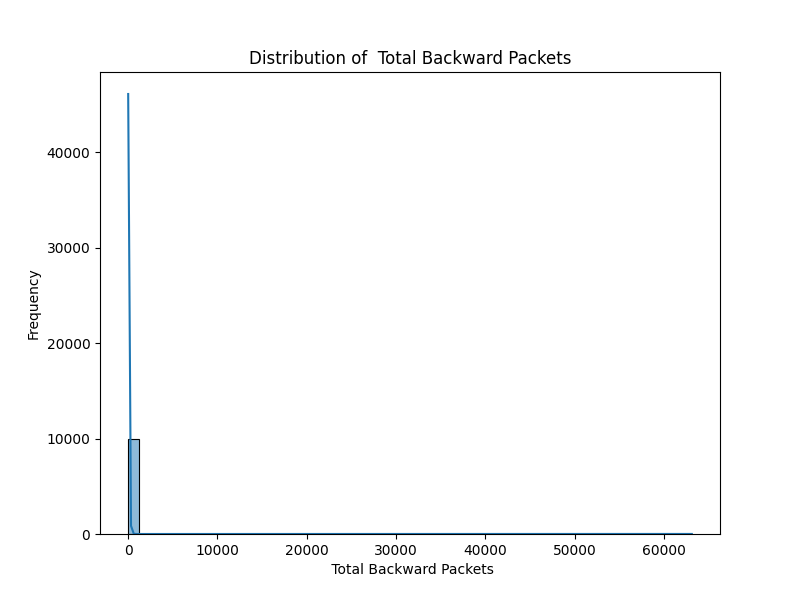

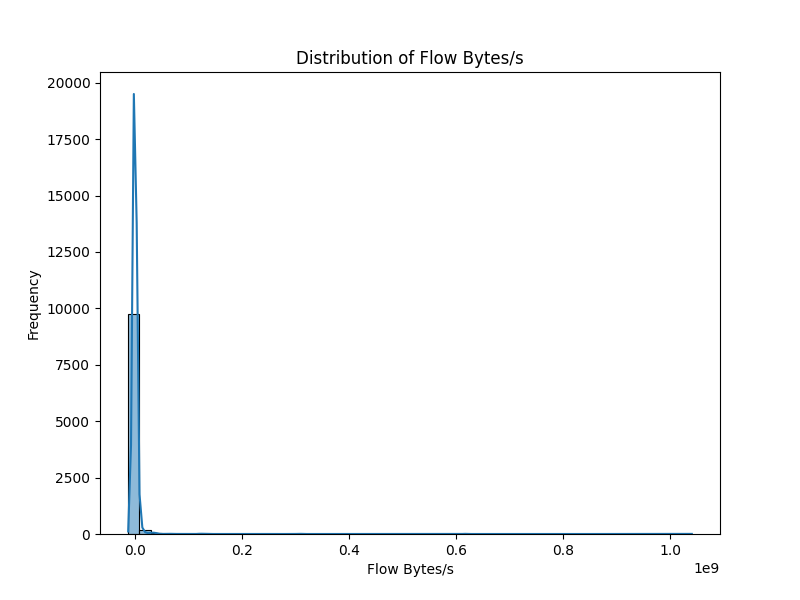

Step 8 - Memory usage: 895.70 MB


In [15]:
# Step 8: Feature Distribution Analysis
def feature_distribution(df):
    print("\nStep 8: Feature Distribution Analysis")
    key_features = [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Flow Bytes/s']
    missing_cols = [col for col in key_features if col not in df.columns]
    if missing_cols:
        print(f"Error: Columns {missing_cols} not found in dataset.")
        return

    sample_df = df[key_features].sample(n=10000, random_state=42)
    for feature in key_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(sample_df[feature], bins=50, kde=True)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.savefig(f'distribution_{feature.replace(" ", "_").replace("/", "_")}.png')
        plt.close()
        display(Image(f'distribution_{feature.replace(" ", "_").replace("/", "_")}.png'))

    print_memory_usage("Step 8")

feature_distribution(df)

In [16]:
# Step 9: Data Preprocessing
def preprocess_data(df):
    print("\nStep 9: Data Preprocessing")
    df = df.drop(' Label', axis=1)

    numerical_cols = df.select_dtypes(include=['float32', 'int32', 'float64', 'int64']).columns
    numerical_cols = [col for col in numerical_cols if col != 'Label']
    if not numerical_cols:
        print("Error: No numerical columns found for scaling.")
        print("Available columns:", df.columns.tolist())
        print("Data types:", df.dtypes)
        return df

    try:
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        # Preserve data types
        for col in numerical_cols:
            if col in df.select_dtypes(include=['int32']).columns:
                df[col] = df[col].astype('int32')
            else:
                df[col] = df[col].astype('float32')
    except ValueError as e:
        print(f"Error during scaling: {e}")
        return df

    def features_to_text(row):
        return " ".join([f"{col}:{row[col]}" for col in numerical_cols])

    chunk_size = 100000
    text_chunks = []
    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start+chunk_size]
        text_chunk = chunk.apply(features_to_text, axis=1)
        text_chunks.append(text_chunk)

    df['text'] = pd.concat(text_chunks, ignore_index=True)
    print("\nSample text representation:")
    print(df['text'].iloc[0])

    df[['text', 'Label']].to_csv('preprocessed_cicids2017.csv', index=False)
    print("\nPreprocessed dataset saved as 'preprocessed_cicids2017.csv'")
    print_memory_usage("Step 9")
    return df

df = preprocess_data(df)


Step 9: Data Preprocessing

Sample text representation:
 Destination Port:2.559312343597412  Flow Duration:-0.4393467605113983  Total Fwd Packets:-0.00981916580349207  Total Backward Packets:-0.010420989245176315 Flow Bytes/s:0.09680185467004776

Preprocessed dataset saved as 'preprocessed_cicids2017.csv'
Step 9 - Memory usage: 1603.63 MB


In [17]:
# Step 10: Summary of Preprocessed Data
def summarize_preprocessed_data(df):
    print("\nStep 10: Summary of Preprocessed Data")
    print("\nShape of preprocessed dataset:")
    print(df[['text', 'Label']].shape)
    print("\nSample data:")
    print(df[['text', 'Label']].head())
    print_memory_usage("Step 10")

summarize_preprocessed_data(df)


Step 10: Summary of Preprocessed Data

Shape of preprocessed dataset:
(2830743, 2)

Sample data:
                                                text  Label
0   Destination Port:2.559312343597412  Flow Dura...      0
1   Destination Port:2.5696494579315186  Flow Dur...      0
2   Destination Port:2.569704055786133  Flow Dura...      0
3   Destination Port:2.08735990524292  Flow Durat...      0
4   Destination Port:2.5592029094696045  Flow Dur...      0
Step 10 - Memory usage: 1603.63 MB


In [18]:
!pip install -U transformers datasets sentence-transformers scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.51.3


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import psutil
import warnings
warnings.filterwarnings('ignore')

# Function to monitor memory usage
def print_memory_usage(step_name):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"{step_name} - Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Step 1: Load Preprocessed Dataset
def load_preprocessed_data():
    print("\nStep 1: Load Preprocessed Dataset")
    file_path = '/content/preprocessed_cicids2017.csv'
    try:
        df = pd.read_csv(file_path)
        # Downsample to 100,000 rows to manage memory
        df = df.sample(n=100000, random_state=42)
        print(f"Downsampled dataset shape: {df.shape}")
        print("\nSample data:")
        print(df.head())
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None

    print_memory_usage("Step 1")
    return df

df = load_preprocessed_data()
if df is None:
    raise SystemExit("Stopping due to error in Step 1.")

# Step 2: Prepare Hugging Face Dataset
def prepare_dataset(df):
    print("\nStep 2: Prepare Hugging Face Dataset")
    # Convert to Hugging Face Dataset
    dataset = Dataset.from_pandas(df[['text', 'Label']])
    # Rename 'Label' to 'labels' for Trainer
    dataset = dataset.rename_column('Label', 'labels')

    # Split into train (80%) and test (20%)
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    print(f"Train dataset size: {len(dataset['train'])}")
    print(f"Test dataset size: {len(dataset['test'])}")

    print_memory_usage("Step 2")
    return dataset

dataset = prepare_dataset(df)

# Step 3: Tokenize Dataset
def tokenize_dataset(dataset):
    print("\nStep 3: Tokenize Dataset")
    tokenizer = AutoTokenizer.from_pretrained("basel/ATTACK-BERT")

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(['text'])
    tokenized_dataset.set_format('torch')

    print("\nSample tokenized data:")
    print(tokenized_dataset['train'][0])
    print_memory_usage("Step 3")
    return tokenized_dataset, tokenizer

tokenized_dataset, tokenizer = tokenize_dataset(dataset)

# Step 4: Initialize Model
def initialize_model():
    print("\nStep 4: Initialize Model")
    model = AutoModelForSequenceClassification.from_pretrained(
        "basel/ATTACK-BERT",
        num_labels=2
    )

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Model moved to {device}")
    print_memory_usage("Step 4")
    return model

model = initialize_model()

Mounted at /content/drive

Step 1: Load Preprocessed Dataset
Downsampled dataset shape: (100000, 2)

Sample data:
                                                      text  Label
746827    Destination Port:-0.4172302186489105  Flow Du...      0
946912    Destination Port:1.0547423362731934  Flow Dur...      1
2216843   Destination Port:-0.4172302186489105  Flow Du...      0
699389    Destination Port:-0.4172302186489105  Flow Du...      0
1170268   Destination Port:-0.43708404898643494  Flow D...      1
Step 1 - Memory usage: 2365.11 MB

Step 2: Prepare Hugging Face Dataset
Train dataset size: 80000
Test dataset size: 20000
Step 2 - Memory usage: 2423.38 MB

Step 3: Tokenize Dataset


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]


Sample tokenized data:
{'labels': tensor(0), '__index_level_0__': tensor(2827603), 'input_ids': tensor([    0,  7692,  3421,  1028,  1019,  1016,  4895,  2585, 22029, 15140,
         2624,  2585, 23781, 28158, 17138,  4838,  9371,  1028,  1015,  1018,
         1016,  4728,  2687, 22026, 12380,  2687, 16072,  2624, 17138, 22936,
         2579,  2565,  1046, 21728, 23734,  1028,  1015,  1018,  1016,  5894,
        14530, 22279,  2696,  2624, 16936, 21490,  2687,  2624, 26228, 24100,
         2565,  8852, 23734,  1028,  1015,  1018,  1016,  4006,  2687, 23636,
         2624, 24438,  2696, 11391, 17469,  2624, 24438, 21930,  4838, 27511,
         1017,  1059,  1028,  1015,  1018,  1016,  5713,  2585, 22614,  2585,
        17138, 25750, 14530, 19321,  2687, 16707,  2553,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,   

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at basel/ATTACK-BERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda
Step 4 - Memory usage: 2506.02 MB


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import psutil
import warnings
warnings.filterwarnings('ignore')

# Function to monitor memory usage
def print_memory_usage(step_name):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"{step_name} - Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Step 5: Define Metrics
def define_metrics():
    print("\nStep 5: Define Metrics")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    print("Metrics defined: accuracy, precision, recall, f1")
    print_memory_usage("Step 5")
    return compute_metrics

compute_metrics = define_metrics()


Step 5: Define Metrics
Metrics defined: accuracy, precision, recall, f1
Step 5 - Memory usage: 2348.59 MB


In [23]:
# Step 6: Configure Training Arguments
def configure_training_args():
    print("\nStep 6: Configure Training Arguments")
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,  # 1 epoch to save time
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,  # Reduce memory usage
        eval_strategy="epoch",  # Updated from evaluation_strategy
        save_strategy="epoch",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none"
    )
    print("Training arguments configured")
    print_memory_usage("Step 6")
    return training_args

training_args = configure_training_args()


Step 6: Configure Training Arguments
Training arguments configured
Step 6 - Memory usage: 2506.12 MB


In [24]:
# Step 7: Initialize Trainer
def initialize_trainer(model, tokenized_dataset, training_args, compute_metrics):
    print("\nStep 7: Initialize Trainer")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test'],
        compute_metrics=compute_metrics
    )
    print("Trainer initialized")
    print_memory_usage("Step 7")
    return trainer

trainer = initialize_trainer(model, tokenized_dataset, training_args, compute_metrics)


Step 7: Initialize Trainer
Trainer initialized
Step 7 - Memory usage: 2506.12 MB


In [ ]:
# Step 8: Train Model
def train_model(trainer):
    print("\nStep 8: Train Model")
    try:
        trainer.train()
        train_log = trainer.state.log_history
        print("\nTraining history:")
        print(train_log)
    except Exception as e:
        print(f"Error during training: {e}")
        return None, None

    print_memory_usage("Step 8")
    return trainer, train_log

trainer, train_log = train_model(trainer)
if trainer is None:
    raise SystemExit("Stopping due to error in Step 8.")


Step 8: Train Model


Epoch,Training Loss,Validation Loss
